<a href="https://colab.research.google.com/github/lmaheshds/EVA6/blob/main/Assignment_S7V4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment S7 brief
The Code flow will be as below

Data-> Dataset-> DataLoader-> Model-> Loss-> Optimizer

1. Package is torchvision
2. Data is CIFAR10.
3. Data loaders to be used is torch.utils.data.DataLoader
4. CIFAR10 classes: ‘airplane’, ‘automobile’, ‘bird’, ‘cat’, ‘deer’, ‘dog’, ‘frog’, ‘horse’, ‘ship’, ‘truck’.
5. The images in CIFAR-10 are of size 3x32x32, i.e. 3-channel color images of 32x32 pixels in size.

# Approach steps
1. GPU conversion and verification
2. Load and normalizing the CIFAR10 training and test datasets using torchvision
3. Define a Convolution Neural Network
4. Define a loss function
5. Train and Test the network
6. Model Plot for the Accuracy





# Libraries installation and Import

In [ ]:
!pip install albumentations==0.4.6
from __future__ import print_function
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
from torchvision.datasets import CIFAR10
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
import random
import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2
%matplotlib inline

     |████████████████████████████████| 122kB 10.5MB/s 
     |████████████████████████████████| 952kB 21.3MB/s 
  Created wheel for albumentations: filename=albumentations-0.4.6-cp37-none-any.whl size=65175 sha256=77617dcf3bbd1b9e8a2a3d920d97fd3cf25b4365b7960f146047b89a71cca81f
  Stored in directory: /root/.cache/pip/wheels/c7/f4/89/56d1bee5c421c36c1a951eeb4adcc32fbb82f5344c086efa14
Successfully built albumentations
  Found existing installation: imgaug 0.2.9
    Uninstalling imgaug-0.2.9:
      Successfully uninstalled imgaug-0.2.9
  Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully uninstalled albumentations-0.1.12


#1. Converting and Verifying the Processor as GPU

In [ ]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)

cuda


# 2. Loading and normalizing CIFAR10
Using torchvision, it’s extremely easy to load CIFAR10.



In [ ]:
class Cifar10SearchDataset(torchvision.datasets.CIFAR10):
    def __init__(self, root="~/data/cifar10", train=True, download=True, transform=None):
        super().__init__(root=root, train=train, download=download, transform=transform)

    def __getitem__(self, index):
        image, label = self.data[index], self.targets[index]

        if self.transform is not None:
            transformed = self.transform(image=image)
            image = transformed["image"]

        return image, label

The output of torchvision datasets are PIL Image, images of range [0, 1]. Transform the images to Tensors between normalized range [-1, 1].

We have used the Albumentations tools for altering the images.

In [ ]:
# Train Phase transformations
stats = ((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))

train_transform = A.Compose([
    A.HorizontalFlip(p=0.4),
    A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, p=0.5),
    A.CoarseDropout(max_holes = 1, max_height=4, max_width=4, min_holes = 1, 
                    min_height=1, min_width=1, fill_value=[0.49139968, 0.48215841, 0.44653091]),
    A.ToGray(p=0.2),
    A.Normalize(mean=(0.49139968, 0.48215841, 0.44653091), std=(0.24703223, 0.24348513, 0.26158784)),
    ToTensorV2(),
])
      
# Test Phase transformations
test_transform = transforms.Compose([
                                      #  transforms.Resize((32, 32)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize(*stats,inplace=True)
                                       ])

trainset = Cifar10SearchDataset('./data', train=True, download=True, transform=train_transform)

testset = datasets.CIFAR10('./data', train=False, download=True, transform=test_transform)

print('trainset',len(trainset))
print('testset', len(testset))


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
trainset 50000
testset 10000


# Dataloader Arguments & Train and Test Dataloaders

In [ ]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something we'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=50, num_workers=2, pin_memory=True) if cuda else dict(shuffle=True, batch_size=50)

# train dataloader
train_loader = torch.utils.data.DataLoader(trainset, **dataloader_args)
# test dataloader
test_loader = torch.utils.data.DataLoader(testset, **dataloader_args)

CUDA Available? True


# Dataset Classes
By using the classes method, we can get the image classes from the dataset.

In [ ]:
classes = trainset.classes
class_count = {}
for _,index in trainset:
  label = classes[index]
  if label not in class_count:
    class_count[label] = 0
  class_count[label] += 1
print(classes)
print(class_count)

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
{'frog': 5000, 'truck': 5000, 'deer': 5000, 'automobile': 5000, 'bird': 5000, 'horse': 5000, 'ship': 5000, 'cat': 5000, 'dog': 5000, 'airplane': 5000}


Let's take a look at some sample images from the training dataloader.

To display the images, we'll need to denormalize the pixels values to bring them back into the range (0,1).

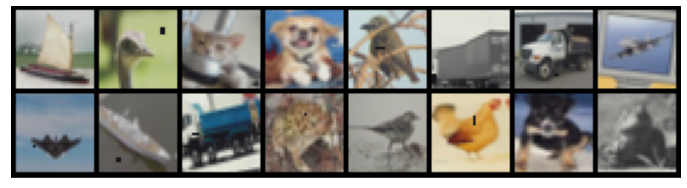

In [ ]:
def denormalize(images, means, stds):
    means = torch.tensor(means).reshape(1, 3, 1, 1)
    stds = torch.tensor(stds).reshape(1, 3, 1, 1)
    return images * stds + means

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([]); ax.set_yticks([])
        denorm_images = denormalize(images, *stats)
        ax.imshow(make_grid(denorm_images[:16], nrow=8).permute(1, 2, 0).clamp(0,1))
        break

show_batch(train_loader)

# 3. Define a Convolution Neural Network

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        # Conv Block1 convolution
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels = 3, out_channels = 40, kernel_size = (3,3), stride = 2, padding = 0),
            nn.BatchNorm2d(40),
            nn.ReLU(),#[input img size=32x32, output img size=32-3+1=30,Jin of input image =1, Jout = Jin * stride = 1*2= 2, RF=input RF + (kernel -1 )* Jin =1+(3-1)*1=3]
            
            nn.Conv2d(in_channels = 40, out_channels = 56, kernel_size = (3,3), stride = 1, padding = 0),
            nn.BatchNorm2d(56),
            # nn.Dropout(0.05),
            nn.ReLU(),#[input img size=30x30, output img size=30-3+1=28,Jin of input image =2, Jout = Jin * stride = 2*1= 2,RF=input RF + (kernel -1 )* Jin =3+(3-1)*2=7]
            
            nn.Conv2d(in_channels = 56, out_channels = 64, kernel_size = (3,3), stride = 1, padding = 0),
            nn.BatchNorm2d(64),
            nn.Dropout(0.05),
            nn.ReLU()#[input img size=28x28, output img size=28-3+1=26,Jin of input image =2, Jout = Jin * stride = 2*1= 2,RF=input RF + (kernel -1 )* Jin =7+(3-1)*2=11]
        ) 
        
        # Conv Block2 Normal convolution in one conv with dilation
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(3,3), dilation =2, stride = 1, padding=0, bias=False), 
            nn.BatchNorm2d(64),
            nn.Dropout(0.05),# Receptive field size= 2(rate-1)*(k-1)+ k 
            nn.ReLU(), 
        )#[input img size=26x26, output img size=26-3+1=24, Jin of input image =2, Jout = Jin * stride = 2*1= 2, RF=2(rate-1)*(k-1)+ k =11+ 7=18]

        # Conv Block3 with Depthwise separable convolution
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(3,3), groups=64, stride = 1, padding=0, bias=False),# Out Img size=68-3+1=66, RF =72+(66-68)=70
            nn.Conv2d(in_channels=64, out_channels=40, kernel_size=(1, 1), stride = 1, padding=0, bias=False),#Out Img=66-1+1= 66, RF = 70 +(66-66)=70
            # nn.BatchNorm2d(256),
            nn.ReLU(),
        ) #[input img size=24x24, output img size=24-3+1=22, Jin of input image =2, Jout = Jin * stride = 2*1= 2, RF=input RF + (kernel -1 )* Jin =18+4=22]
          #[input img size=22x22, output img size=22-1+1=22, Jin of input image =2, Jout = Jin * stride = 2*1= 2, RF=input RF + (kernel -1 )* Jin =22+0=22]

        # Conv Block4 with Depthwise separable convolution
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=40, out_channels=40, kernel_size=(3,3), groups=40, stride = 1, padding=0, bias=False),# Out Img size=67-3+1=65, RF =40+(65-67)= 38
            nn.Conv2d(in_channels=40, out_channels=32, kernel_size=(1, 1), stride = 1, padding=0, bias=False),#Out Img=65-1+1= 65, RF = 38 +(65-65)= 38
            # nn.BatchNorm2d(256),
            nn.ReLU(),
        )#[input img size=22x22, output img size=22-3+1=20, Jin of input image =2, Jout = Jin * stride = 2*1= 2, RF=input RF + (kernel -1 )* Jin =22+4=26]
          #[input img size=20x20, output img size=20-1+1=20, Jin of input image =2, Jout = Jin * stride = 2*1= 2, RF=input RF + (kernel -1 )* Jin =26+0=26]  
                
        # OUTPUT BLOCK
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(3,3), groups=32, stride = 1, padding=0, bias=False),
            nn.Conv2d(in_channels=32, out_channels=10, kernel_size=(1, 1), stride = 1,padding=0, bias=False),# Output img size=71+ 0=71, RF = 56+0=56
            #nn.Dropout(0.05),
            nn.ReLU()
        ) #[input img size=20x20, output img size=20-3+1=18, Jin of input image =2, Jout = Jin * stride = 2*1= 2, RF=input RF + (kernel -1 )* Jin =26+4=30]
          #[input img size=18x18, output img size=18-1+1=18, Jin of input image =2, Jout = Jin * stride = 2*1= 2, RF=input RF + (kernel -1 )* Jin =30+0=30] 


        #self.avg = nn.AvgPool2d(6, ceil_mode=True) # global average pooling
        self.gap = nn.Sequential(
            nn.AvgPool2d(10, ceil_mode=True)
        )
        
    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.gap(x)
        # # #x = x.view(x.size(0),-1)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)   
        #return x 

# Estimating Model Params

In [ ]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(3, 32, 32))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 40, 15, 15]           1,120
       BatchNorm2d-2           [-1, 40, 15, 15]              80
              ReLU-3           [-1, 40, 15, 15]               0
            Conv2d-4           [-1, 56, 13, 13]          20,216
       BatchNorm2d-5           [-1, 56, 13, 13]             112
              ReLU-6           [-1, 56, 13, 13]               0
            Conv2d-7           [-1, 64, 11, 11]          32,320
       BatchNorm2d-8           [-1, 64, 11, 11]             128
           Dropout-9           [-1, 64, 11, 11]               0
             ReLU-10           [-1, 64, 11, 11]               0
           Conv2d-11             [-1, 64, 7, 7]          36,864
      BatchNorm2d-12             [-1, 64, 7, 7]             128
          Dropout-13             [-1, 64, 7, 7]               0
             ReLU-14             [

# 4. Define a loss function

In [ ]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

# 5. Train and Test the network on the training data

In [ ]:
model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.018, momentum=0.9)
EPOCHS = 30
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

  0%|          | 0/1000 [00:00<?, ?it/s]

EPOCH: 0


Loss=1.4095442295074463 Batch_id=999 Accuracy=26.58: 100%|██████████| 1000/1000 [00:26<00:00, 37.95it/s]
  0%|          | 0/1000 [00:00<?, ?it/s]


Test set: Average loss: 1.4844, Accuracy: 4547/10000 (45.47%)

EPOCH: 1


Loss=1.3269126415252686 Batch_id=999 Accuracy=49.77: 100%|██████████| 1000/1000 [00:25<00:00, 38.95it/s]
  0%|          | 0/1000 [00:00<?, ?it/s]


Test set: Average loss: 1.3536, Accuracy: 5300/10000 (53.00%)

EPOCH: 2


Loss=1.0714342594146729 Batch_id=999 Accuracy=58.51: 100%|██████████| 1000/1000 [00:26<00:00, 38.04it/s]
  0%|          | 0/1000 [00:00<?, ?it/s]


Test set: Average loss: 1.0650, Accuracy: 6337/10000 (63.37%)

EPOCH: 3


Loss=0.9182867407798767 Batch_id=999 Accuracy=63.20: 100%|██████████| 1000/1000 [00:26<00:00, 37.96it/s]
  0%|          | 0/1000 [00:00<?, ?it/s]


Test set: Average loss: 0.9972, Accuracy: 6685/10000 (66.85%)

EPOCH: 4


Loss=0.9655371904373169 Batch_id=999 Accuracy=66.63: 100%|██████████| 1000/1000 [00:26<00:00, 38.37it/s]
  0%|          | 0/1000 [00:00<?, ?it/s]


Test set: Average loss: 0.8535, Accuracy: 7072/10000 (70.72%)

EPOCH: 5


Loss=0.6869574189186096 Batch_id=999 Accuracy=68.90: 100%|██████████| 1000/1000 [00:26<00:00, 37.62it/s]
  0%|          | 0/1000 [00:00<?, ?it/s]


Test set: Average loss: 0.8144, Accuracy: 7224/10000 (72.24%)

EPOCH: 6


Loss=0.6600573062896729 Batch_id=999 Accuracy=70.79: 100%|██████████| 1000/1000 [00:26<00:00, 37.61it/s]
  0%|          | 0/1000 [00:00<?, ?it/s]


Test set: Average loss: 0.7406, Accuracy: 7467/10000 (74.67%)

EPOCH: 7


Loss=0.9063968062400818 Batch_id=999 Accuracy=72.01: 100%|██████████| 1000/1000 [00:26<00:00, 38.14it/s]
  0%|          | 0/1000 [00:00<?, ?it/s]


Test set: Average loss: 0.7270, Accuracy: 7511/10000 (75.11%)

EPOCH: 8


Loss=0.4213894307613373 Batch_id=999 Accuracy=73.22: 100%|██████████| 1000/1000 [00:26<00:00, 38.18it/s]
  0%|          | 0/1000 [00:00<?, ?it/s]


Test set: Average loss: 0.7279, Accuracy: 7535/10000 (75.35%)

EPOCH: 9


Loss=0.8349788188934326 Batch_id=999 Accuracy=73.95: 100%|██████████| 1000/1000 [00:26<00:00, 37.27it/s]
  0%|          | 0/1000 [00:00<?, ?it/s]


Test set: Average loss: 0.7550, Accuracy: 7445/10000 (74.45%)

EPOCH: 10


Loss=0.5445789694786072 Batch_id=999 Accuracy=74.47: 100%|██████████| 1000/1000 [00:26<00:00, 37.79it/s]
  0%|          | 0/1000 [00:00<?, ?it/s]


Test set: Average loss: 0.7440, Accuracy: 7511/10000 (75.11%)

EPOCH: 11


Loss=0.636503279209137 Batch_id=999 Accuracy=75.52: 100%|██████████| 1000/1000 [00:27<00:00, 36.87it/s]
  0%|          | 0/1000 [00:00<?, ?it/s]


Test set: Average loss: 0.7246, Accuracy: 7624/10000 (76.24%)

EPOCH: 12


Loss=0.5626000761985779 Batch_id=999 Accuracy=75.98: 100%|██████████| 1000/1000 [00:26<00:00, 37.91it/s]
  0%|          | 0/1000 [00:00<?, ?it/s]


Test set: Average loss: 0.6181, Accuracy: 7910/10000 (79.10%)

EPOCH: 13


Loss=0.7613948583602905 Batch_id=999 Accuracy=76.30: 100%|██████████| 1000/1000 [00:26<00:00, 37.32it/s]
  0%|          | 0/1000 [00:00<?, ?it/s]


Test set: Average loss: 0.6711, Accuracy: 7743/10000 (77.43%)

EPOCH: 14


Loss=0.6607082486152649 Batch_id=999 Accuracy=77.04: 100%|██████████| 1000/1000 [00:26<00:00, 37.52it/s]
  0%|          | 0/1000 [00:00<?, ?it/s]


Test set: Average loss: 0.7383, Accuracy: 7560/10000 (75.60%)

EPOCH: 15


Loss=0.786210834980011 Batch_id=999 Accuracy=77.59: 100%|██████████| 1000/1000 [00:26<00:00, 37.07it/s]
  0%|          | 0/1000 [00:00<?, ?it/s]


Test set: Average loss: 0.6542, Accuracy: 7828/10000 (78.28%)

EPOCH: 16


Loss=0.6991320252418518 Batch_id=999 Accuracy=77.87: 100%|██████████| 1000/1000 [00:26<00:00, 37.74it/s]
  0%|          | 0/1000 [00:00<?, ?it/s]


Test set: Average loss: 0.6146, Accuracy: 7901/10000 (79.01%)

EPOCH: 17


Loss=0.5817660689353943 Batch_id=999 Accuracy=77.75: 100%|██████████| 1000/1000 [00:26<00:00, 37.25it/s]
  0%|          | 0/1000 [00:00<?, ?it/s]


Test set: Average loss: 0.6153, Accuracy: 7918/10000 (79.18%)

EPOCH: 18


Loss=0.6655513644218445 Batch_id=999 Accuracy=78.56: 100%|██████████| 1000/1000 [00:26<00:00, 37.38it/s]
  0%|          | 0/1000 [00:00<?, ?it/s]


Test set: Average loss: 0.6488, Accuracy: 7868/10000 (78.68%)

EPOCH: 19


Loss=0.6405755877494812 Batch_id=999 Accuracy=78.84: 100%|██████████| 1000/1000 [00:26<00:00, 37.15it/s]
  0%|          | 0/1000 [00:00<?, ?it/s]


Test set: Average loss: 0.6983, Accuracy: 7655/10000 (76.55%)

EPOCH: 20


Loss=0.5150184631347656 Batch_id=999 Accuracy=78.97: 100%|██████████| 1000/1000 [00:26<00:00, 37.55it/s]
  0%|          | 0/1000 [00:00<?, ?it/s]


Test set: Average loss: 0.6075, Accuracy: 7972/10000 (79.72%)

EPOCH: 21


Loss=0.5184347629547119 Batch_id=999 Accuracy=79.32: 100%|██████████| 1000/1000 [00:26<00:00, 37.88it/s]
  0%|          | 0/1000 [00:00<?, ?it/s]


Test set: Average loss: 0.5987, Accuracy: 8010/10000 (80.10%)

EPOCH: 22


Loss=0.4128665030002594 Batch_id=999 Accuracy=79.59: 100%|██████████| 1000/1000 [00:26<00:00, 38.01it/s]
  0%|          | 0/1000 [00:00<?, ?it/s]


Test set: Average loss: 0.5960, Accuracy: 7991/10000 (79.91%)

EPOCH: 23


Loss=0.4432058334350586 Batch_id=999 Accuracy=79.78: 100%|██████████| 1000/1000 [00:26<00:00, 37.58it/s]
  0%|          | 0/1000 [00:00<?, ?it/s]


Test set: Average loss: 0.6080, Accuracy: 8031/10000 (80.31%)

EPOCH: 24


Loss=0.6179383993148804 Batch_id=999 Accuracy=80.14: 100%|██████████| 1000/1000 [00:25<00:00, 38.73it/s]
  0%|          | 0/1000 [00:00<?, ?it/s]


Test set: Average loss: 0.5737, Accuracy: 8058/10000 (80.58%)

EPOCH: 25


Loss=0.9626366496086121 Batch_id=999 Accuracy=80.14: 100%|██████████| 1000/1000 [00:26<00:00, 37.59it/s]
  0%|          | 0/1000 [00:00<?, ?it/s]


Test set: Average loss: 0.6539, Accuracy: 7928/10000 (79.28%)

EPOCH: 26


Loss=0.6048506498336792 Batch_id=999 Accuracy=80.54: 100%|██████████| 1000/1000 [00:26<00:00, 37.49it/s]
  0%|          | 0/1000 [00:00<?, ?it/s]


Test set: Average loss: 0.6193, Accuracy: 7980/10000 (79.80%)

EPOCH: 27


  0%|          | 0/1000 [00:00<?, ?it/s]


Test set: Average loss: 0.5825, Accuracy: 8101/10000 (81.01%)

EPOCH: 28


Loss=0.6827728152275085 Batch_id=999 Accuracy=80.91: 100%|██████████| 1000/1000 [00:25<00:00, 38.54it/s]
  0%|          | 0/1000 [00:00<?, ?it/s]


Test set: Average loss: 0.5521, Accuracy: 8209/10000 (82.09%)

EPOCH: 29


Loss=0.42046287655830383 Batch_id=999 Accuracy=81.14: 100%|██████████| 1000/1000 [00:26<00:00, 37.27it/s]



Test set: Average loss: 0.5816, Accuracy: 8062/10000 (80.62%)



# 6. Model plot for Accuracy

Text(0.5, 1.0, 'Test Accuracy')

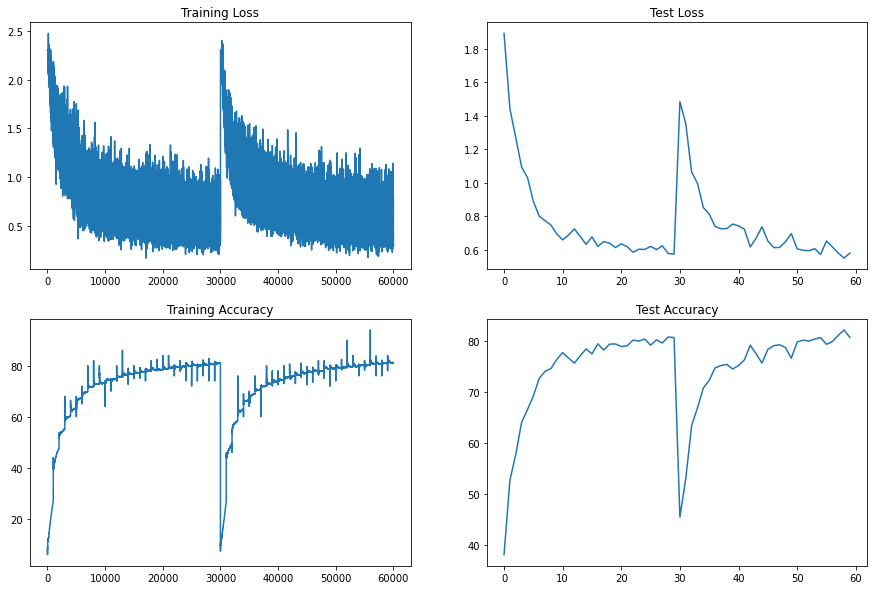

In [ ]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")

# Network Accuracy

In [ ]:
correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %.3f %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 80.620 %


# Accuracy for each classes

In [ ]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of airplane : 87 %
Accuracy of automobile : 93 %
Accuracy of  bird : 79 %
Accuracy of   cat : 77 %
Accuracy of  deer : 61 %
Accuracy of   dog : 62 %
Accuracy of  frog : 95 %
Accuracy of horse : 96 %
Accuracy of  ship : 92 %
Accuracy of truck : 87 %
